In this assignment we will look at a typical image based machine learning task.

## Image classification 

For this task the whole image is used to classify what's happening.

For this specific task, we will be trying to classify COVID-19 using pneumonia x-rays.  Please note, the literature has mostly suggested CT scans are not an effective way of figuring out what type of disease you have.  This exercise is for academic purposes _only_.

Steps:


1. Download the pneumonia data.  

You can find it here:

https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

move the folder to this directory and unzip it.  Please don't change any folder names or the below script will not work.  Also make sure the folder is in the same directory as this notebook!

2. load the pneumonia data into a dataframe:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import pandas as pd
import cv2
import os
import os.path as op
import numpy as np
import glob
from PIL import Image
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import skimage.transform
import skimage.color
from sklearn.metrics import classification_report
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, AveragePooling2D
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from tensorflow.keras.callbacks import EarlyStopping

runtime_lim = True
num_sample = 1000
if runtime_lim:
    import random
    random.seed(23)

In [0]:
import glob

def load_training_data():
    paths = [
        "/content/drive/My Drive/chest_xray/train/NORMAL/*",
        "/content/drive/My Drive/chest_xray/train/PNEUMONIA/*"
    ]
    labels = []
    image_paths = []
    for path in paths:
        for im_path in glob.glob(path):
            if path == "/content/drive/My Drive/chest_xray/train/NORMAL/*":
                labels.append("NORMAL")
            if path == "/content/drive/My Drive/chest_xray/train/PNEUMONIA/*":
                labels.append("PNEUMONIA")
            image_paths.append(im_path)
    return image_paths, labels

def load_testing_data():
    paths = [
        "/content/drive/My Drive/chest_xray/test/NORMAL/*",
        "/content/drive/My Drive/chest_xray/test/PNEUMONIA/*"
    ]
    labels = []
    image_paths = []
    for path in paths:
        for im_path in glob.glob(path):
            if path == "/content/drive/My Drive/chest_xray/test/NORMAL/*":
                labels.append("NORMAL")
            if path == "/content/drive/My Drive/chest_xray/test/PNEUMONIA/*":
                labels.append("PNEUMONIA")
            image_paths.append(im_path)
    return image_paths, labels

train_paths, train_labels = load_training_data()
test_paths, test_labels = load_training_data()

In [8]:
train_paths[:5]

['/content/drive/My Drive/chest_xray/train/NORMAL/IM-0545-0001.jpeg',
 '/content/drive/My Drive/chest_xray/train/NORMAL/IM-0551-0001-0002.jpeg',
 '/content/drive/My Drive/chest_xray/train/NORMAL/IM-0539-0001-0001.jpeg',
 '/content/drive/My Drive/chest_xray/train/NORMAL/IM-0538-0001.jpeg',
 '/content/drive/My Drive/chest_xray/train/NORMAL/IM-0543-0001-0002.jpeg']

3. read the data into memory, I recommend open-cv for this:

`python -m pip install opencv-python` 

if you don't already have it!

In [0]:
def preprocess_images(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (img_size, img_size))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    img = np.array(img)/255.0
    return img

In [0]:
def load_images(image_paths):
    images = []
    for image_path in image_paths:
        image = preprocess_images(image_path)
        images.append(image)
    return np.stack(np.array(images), 0)

In [0]:
#load train images
train_images = load_images(train_paths)
#load test images
test_images = load_images(test_paths)

4. resize the images to a standard size - 

Note: it ought to be a box.  So the width and height should be the same size.

In [0]:
def resize_images(images):
    resizedimages = []
    for img in images:
        img = cv2.resize(img,(100,100), interpolation = cv2.INTER_LINEAR)
        resizedimages.append(img)
    return resizedimages

In [0]:
train_images = resize_images(train_images)
test_images = resize_images(test_images)

In [0]:
train_images[0].shape

(100, 100, 3)

5. Greyscale the images

In [0]:
def greyscale_images(images):
    grayimages=[]
    for img in images:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        grayimages.append(img)
    return grayimages

In [0]:
train_images = greyscale_images(train_images)
test_images = greyscale_images(test_images)

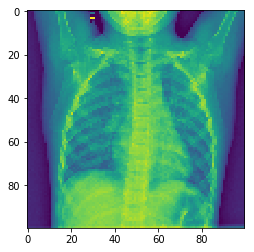

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(train_images[0])

In [0]:
train_labels_np = np.array(train_labels)
test_labels_np = np.array(test_labels)

6. prepare the data for training the model.

For this you'll need to transform the test and train image objects into a numpy array.

In [0]:
def features_to_np_array(image_paths, shape):
    height, width, channels = shape
    array = np.zeros((len(image_paths), height, width, channels))
    for i, path in enumerate(image_paths):
        im = Image.open(path)
        as_array = np.asarray(im)
        if len(as_array.shape) == 2: 
            as_array = skimage.color.gray2rgb(as_array)
        resized = skimage.transform.resize(as_array, shape)
        array[i,:,:] = resized
        if (i + 1) % 2000 == 0:
            print(f'{i+1} images loaded')
            i= i+1
    return array

Next you'll need to do the same for the labels:

Note: You'll need to apply the `to_categorical` function after transforming to a numpy array

In [13]:
label_type = { label: i for i, label in enumerate(set(train_labels)) }
label_type

{'NORMAL': 0, 'PNEUMONIA': 1}

In [0]:
image_shape = (100, 100, 3)
#X_value = features_to_np_array(train_paths, image_shape)
#Y_value = labels_to_np_array(train_labels, label_type)

In [0]:
def labels_to_np_array(labels):
    lb = LabelBinarizer()
    labels = lb.fit_transform(labels)
    labels = to_categorical(labels)
    return labels

train_labels = labels_to_np_array(train_labels)
test_labels = labels_to_np_array(test_labels)

7. Seperate into train and test with `train_test_split` from scikit-learn

In [15]:
train_images1 = train_images[:1000]
train_labels1 = train_labels[:1000]
print(train_images1.shape)
train_labels1.shape

(1000, 100, 100, 3)


(1000, 2)

In [0]:
1# train test split code goes here
from sklearn.model_selection import train_test_split

#X_train, X_test, Y_train, Y_test = train_test_split(X_value, Y_value, test_size=0.33, random_state=42)
(X_train, X_test, Y_train, Y_test) = train_test_split(train_images1, train_labels1, test_size=0.33, stratify=train_labels1)

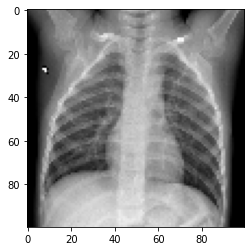

In [139]:
plt.imshow(X_train[0])

8. Make the last four layers of VGG16 with imagenet weights trainable and then retrain the model.

To understand how to do this, please see the following tutorial:

https://www.learnopencv.com/keras-tutorial-fine-tuning-using-pre-trained-models/

In [17]:
# your model and training code goes here
image_shape = (100, 100, 3)
from tensorflow.keras.applications import VGG16
from tensorflow.python.framework import ops
ops.reset_default_graph()
#Load the VGG model
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape =image_shape )

58892288/58889256 [==============================] - 1s 0us/step


In [18]:
#Freeze the layers except the last 4 layers
for layer in vgg_conv.layers[:-4]:
    layer.trainable = False

for layer in vgg_conv.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f62a9fd2940> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f62aa0a6e48> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f62a9f68128> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f62a9e297b8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f62a9e29630> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f62a9e37978> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f62a9e40b38> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f62a9e409b0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f62a9e48cf8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f62a9e50438> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f62a9e51358> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 

In [19]:
from tensorflow.keras import models,layers,optimizers

model = models.Sequential()
model.add(vgg_conv)
 
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='softmax'))
model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              4719616   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2050      
Total params: 19,436,354
Trainable params: 11,801,090
Non-trainable params: 7,635,264
_________________________________________________________________


In [20]:
#model.compile(loss='sparse_categorical_crossentropy',optimizer=optimizers.RMSprop(lr=1e-4),metrics=['acc'])
opt = "adam"
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])
model.fit(X_train, Y_train, epochs= 5, batch_size= 128, validation_split=0.2)

Epoch 1/5
5/5 [==============================] - 61s 12s/step - loss: 0.1026 - acc: 0.9590 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 2/5
5/5 [==============================] - 61s 12s/step - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 3/5
5/5 [==============================] - 61s 12s/step - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 4/5
5/5 [==============================] - 63s 13s/step - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 5/5
5/5 [==============================] - 62s 12s/step - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000


In [0]:
MainModel = vgg_conv.output
MainModel = AveragePooling2D(pool_size=(3, 3))(MainModel)
MainModel = Flatten(name="flatten")(MainModel)
MainModel = Dense(64, activation="relu")(MainModel)
MainModel = Dropout(0.5)(MainModel)
MainModel = Dense(2, activation="softmax")(MainModel)

model = Model(inputs=vgg_conv.input, outputs=MainModel)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [48]:
model.fit(X_train[:20], Y_train[:20], validation_split=0.2, epochs=5, batch_size=5, verbose=0)


8. Check your score with classification_report from scikit-learn

Now that you've trained your model, call `model.predict` to get the predicted values for classification.  
Then compare your predicted values with y_test

In [49]:
y_pred = model.predict(X_test)
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       330
           1       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00       330
   macro avg       0.50      0.50      0.50       330
weighted avg       1.00      1.00      1.00       330
 samples avg       1.00      1.00      1.00       330



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


9. Data augmentation

Now that you have a classifier, let's see if data augmentation improves things!  

You can use the `ImageDataGenerator` that comes with keras.  Here's how to import it:

`from tensorflow.keras.preprocessing.image import ImageDataGenerator`

Here's the documentation: https://keras.io/preprocessing/image/

Here's an example of it getting used in the wild, in case you get stuck:

https://www.pyimagesearch.com/2020/03/16/detecting-covid-19-in-x-ray-images-with-keras-tensorflow-and-deep-learning/

In [0]:
#augment your data here
from tensorflow.keras.preprocessing.image import ImageDataGenerator

augDataGen = ImageDataGenerator(rotation_range=20,fill_mode='nearest')
train_batchsize = 100
val_batchsize = 10


trainGen = augDataGen.flow(X_train, Y_train, batch_size=128)

10. retrain your classifier

Now that you have augmented training data, please retrain your classifier.  The code should basically be the same.

In [51]:
# Create the model
augmented_model = models.Sequential()

# new training code goes here
augmented_model.add(vgg_conv)
augmented_model.add(layers.Flatten())
augmented_model.add(layers.Dense(64, activation='relu'))
augmented_model.add(layers.Dropout(0.5))
augmented_model.add(layers.Dense(2, activation='softmax'))
augmented_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])
augmented_model.fit_generator(trainGen, steps_per_epoch=len(X_train)/128, validation_data=(X_test, Y_test), validation_steps=len(X_test)/128,epochs=5)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
6/5 [==================================] - 97s 16s/step - loss: 0.0876 - acc: 0.9896 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 2/5
6/5 [==================================] - 96s 16s/step - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 3/5
6/5 [==================================] - 97s 16s/step - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 4/5
6/5 [==================================] - 96s 16s/step - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 5/5
6/5 [==================================] - 96s 16s/step - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000


11. re-evaluate your classifier

Now that you've augmented the data, please re-evaluate your classifer.  Use classification report like before.

In [0]:
print(classification_report(Y_test, y_pred))

12. Evaluate the difference with data augmentation and without:

Did things improve?  Did they stay the same?  Did they get worse?  Please try to come up with an explanation of why you got the results you did.

* Yes thing improved using data agumentation improvement in the precision and recall after doing data agumentation 
* Result without data  augmentation acc was 96% but the model was overfitting due to small no of images
* with data augmentation acc was less compares to previous model 

### Explanation of results go here

13. Getting COVID19 data

Now that you have a trained classifier with pneumonia, we are going to use this with COVID data.  

Clone this repo:

https://github.com/ieee8023/covid-chestxray-dataset

use the clone command: `git clone [REPO]`

to get the data locally.  

Make sure to run this command in the same folder as this jupyter notebook.

14. Read the data into memory

The set up for this data repository is a little different.  Please use the following code to read the data into memory:

In [0]:
import pandas as pd

def get_covid19():
    base = "/content/drive/My Drive/covid-chestxray-dataset/"
    metadata = pd.read_csv(base+"metadata.csv")
    #metadata = pd.readd_csv("/content/drive/My Drive/covid-chestxray-dataset/metadata.csv")
    labels = []
    image_paths = []
    for index, row in metadata.iterrows():
        labels.append(row["finding"])
        image_paths.append(base+row["filename"])
    return labels, image_paths

labels, covid_image_paths = get_covid19()


In [0]:
#covid_image_paths
label_list = []
image_path_list = []
for (label, image_path) in zip(labels, covid_image_paths):
    if (label == 'COVID-19') or (label == 'No Finding'):
        label_list.append(label)
        image_path_list.append(image_path)


15. preprocess images

you'll need to run the following functions on this data:

1. load_images
2. resize_images
3. greyscale_images
4. features_to_np_array
5. labels_to_np_array

Make sure to run each of those functions in order!

In [0]:
def load_images(image_paths):
    images = []
    for image_path in image_paths:
        image = preprocess_images(image_path)
        images.append(image)
    return np.stack(np.array(images), 0)

In [0]:
img_size =100
def preprocess_images(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (img_size, img_size))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    img = np.array(img)/255.0
    return img


In [0]:
categorical = { label: i for i, label in enumerate(set(labels)) }
categorical

{'Streptococcus': 0,
 'COVID-19, ARDS': 1,
 'ARDS': 2,
 'Legionella': 3,
 'SARS': 4,
 'No Finding': 5,
 'Chlamydophila': 6,
 'Pneumocystis': 7,
 'Klebsiella': 8,
 'COVID-19': 9,
 'E.Coli': 10}

In [0]:
def labels_to_np_array(labels, mapping):
    return np.array([mapping[label] for label in labels])

In [0]:
covid_image_paths[:10]

['covid-chestxray-dataset/images/auntminnie-a-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg',
 'covid-chestxray-dataset/images/auntminnie-b-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg',
 'covid-chestxray-dataset/images/auntminnie-c-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg',
 'covid-chestxray-dataset/images/auntminnie-d-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg',
 'covid-chestxray-dataset/images/nejmc2001573_f1a.jpeg',
 'covid-chestxray-dataset/images/nejmc2001573_f1b.jpeg',
 'covid-chestxray-dataset/images/ARDSSevere.png',
 'covid-chestxray-dataset/images/lancet-case2a.jpg',
 'covid-chestxray-dataset/images/lancet-case2b.jpg',
 'covid-chestxray-dataset/images/SARS-10.1148rg.242035193-g04mr34g0-Fig8a-day0.jpeg']

16. Strip out labels other than 'No Finding' and 'COVID-19' from the dataset

There are two straight forward ways to do this:

1) use a for-loop and keep track of indices

2) read labels and features into a dataframe and then filter to those two label types.  Your choice!

In [0]:
#prediction code goes here
take_only = 200
import cv2
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import glob
import code

def extract_features_covid(model, width, height):
    base = "/content/drive/My Drive/covid-chestxray-dataset/"
    im_base = "/content/drive/My Drive/covid-chestxray-dataset/images/"
    metadata = pd.read_csv(base+"metadata.csv")
    labels = []
    feature_list = []
    image_paths = []
    for index, row in metadata.iterrows():
        if row["finding"] == "COVID-19" and ".gz" not in row["filename"]:
            labels.append("COVID")
            im_path = im_base+row["filename"]
            image_paths.append(im_path)
            im = np.expand_dims(preprocess_images(im_path), axis=0)
            features = model.predict(im)
            features_np = np.array(features)
            feature_list.append(features_np.flatten())

    return np.array(feature_list), labels

def extract_features_not_covid(model, width, height):
    feature_list = []
    labels = []
    paths = [
      "/content/drive/My Drive/chest_xray/test/NORMAL/*",
      "/content/drive/My Drive/chest_xray/test/PNEUMONIA/*",
      "/content/drive/My Drive/chest_xray/train/NORMAL/*",
      "/content/drive/My Drive/chest_xray/train/PNEUMONIA/*"
    ] 
    count_train = 0
    count_test = 0
    count_pneumonia = 0
    count_data = 0
    for path in paths:
        for im_path in glob.glob(path):
            count = False
            if path == "/content/drive/My Drive/chest_xray/train/NORMAL/*" and count_train < take_only:
                labels.append("CLEAR TRAIN")
                count_train += 1
                count = True
            if path == "/content/drive/My Drive/chest_xray/test/NORMAL/*" and count_test < take_only:
                labels.append("CLEAR TEST")
                count_test += 1
                count = True
            if path == "/content/drive/My Drive/chest_xray/train/PNEUMONIA/*" and count_pneumonia < take_only:
                labels.append("PNEUMONIA")
                count_pneumonia += 1
                count = True
            if count:
               # im = np.expand_dims(get_image_features(im_path), axis=0)
                im = np.expand_dims(preprocess_images(im_path), axis=0)
                features = model.predict(im)
                features_np = np.array(features)
                feature_list.append(features_np.flatten())

    return np.array(feature_list), labels

# please make a copy of your tuned model and save it to variable:
untuned_model = model

# please specify the width and height you used for the image preprocessing
width = 100
height = 100

covid_features, covid_labels = extract_features_covid(untuned_model, width, height)
non_covid_features, non_covid_labels = extract_features_not_covid(untuned_model, width, height)

covid_features = (covid_features > 0.5)
covid_features = np.argmax(covid_features, axis=1) 

non_covid_features = (non_covid_features > 0.5)
non_covid_features = np.argmax(non_covid_features, axis=1) 

features = np.concatenate([covid_features, non_covid_features])
labels = np.concatenate([covid_labels, non_covid_labels])

X_train1 = []
y_train1 = []
X_test1 = []
y_test1 = []
for index, label in enumerate(labels):
    if label == "CLEAR TRAIN":
        X_train1.append(features[index])
        y_train1.append(0)
    if label == "PNEUMONIA":
        X_train1.append(features[index])
        y_train1.append(1)
    if label == "COVID":
        X_test1.append(features[index])
        y_test1.append(1)
    if label == "CLEAR TEST":
        X_test1.append(features[index])
        y_test1.append(0)



17. Predict on the new images

Here you'll use the classifier you trained on just pneumonia/not pneumonia to try and classify COVID-19 and no finding.  You'll use the pneumonia/not pneumonia classifier as a featurizer to do this.

Much of the code has been written, you'll just need to supply your trained classifier as input.

Please predict the labels from the classifier.  Then run `classification_report` to see how well your classifier did.

In [29]:
X_train1 = np.array(X_train1).reshape(-1, 1)
y_train1 = np.array(y_train1).reshape(-1, 1)
X_test1 = np.array(X_test1).reshape(-1, 1)
y_test1 = np.array(y_test1).reshape(-1, 1)

logit_clf = LogisticRegression()
logit_clf.fit(X_train1, y_train1)
y_pred = logit_clf.predict(X_test1)
print(classification_report(y_test1, y_pred))

              precision    recall  f1-score   support

           0       0.39      1.00      0.56       200
           1       0.00      0.00      0.00       319

    accuracy                           0.39       519
   macro avg       0.19      0.50      0.28       519
weighted avg       0.15      0.39      0.21       519



/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


18. Compare and contrast how the classifier did on Pneumonia versus COVID-19

Did it do as well?  Worse?  About the same?  What conclusions can you draw?

### Add your answers here!

Since there are few covid images comapred to pneumonia so, model did not perform well 

In [0]:
#Train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_images1, train_labels1, test_size=0.33, random_state=52)

def new_model(activation='relu', optimizer='adam', dropout_rate=0.5, trainable_range=-4, num_nodes=64):
    keras.backend.clear_session()
    vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(100, 100, 3))
    # Only allow the last x layers trainable
    for layer in vgg_conv.layers[:trainable_range]:
        layer.trainable = False
        model = models.Sequential()
        model.add(vgg_conv)
        model.add(layers.Flatten())
        model.add(layers.Dense(num_nodes, activation=activation))
        model.add(layers.Dropout(dropout_rate))
        model.add(layers.Dense(2, activation='softmax'))
        model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['acc'])
    return model

Now that we've looked at a bunch of base cases, let's see if we can improve things by changing the model architecture.  We'll do this with a bunch of discrete steps

1. Change the number of trainable layers

Here you will make more of the layers trainable.  For this we are going to use cross validation to try and figure out which the optimal number of trainable layers.  Please us from the last 6 layers to one layer.  So your range should be:

```
trainable_range = [-6, -5, -4, -3, -2, -1]
```

Also, your X and y data should be the pneumonia data only.  Since that's what we trained on.  We should not assume we have access to the COVID data, except for testing, which will do later on.

Here's a blog post detailing how to set this up: https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

Note you'll need to set the number of trainable layers inside of `model_create` in order to make this tunable.  

Please report mean and standard deviation for accuracy.

In [31]:
from sklearn.model_selection import StratifiedKFold

seed = 34
np.random.seed(seed)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed
grid_model = KerasClassifier(build_fn=new_model, batch_size=128, epochs=5, verbose=0)

trainable_range = [-6, -5,-4,-3, -2,-1]
param_grid = dict(trainable_range=trainable_range)

grid = GridSearchCV(estimator=grid_model, param_grid=param_grid, n_jobs=1, verbose=0)

grid_res = grid.fit(X_train[:5], y_train[:5])

print("Best: %f using %s" % (grid_res.best_score_, grid_res.best_params_))

Best: 1.000000 using {'trainable_range': -6}


In [32]:
# Cross validation code goes here
best_trainable_range = grid_res.best_params_['trainable_range']

scores = []

y_train_label = np.argmax(y_train, axis=1)

for train, test in kfold.split(X_train, y_train_label):
    model = new_model(trainable_range = best_trainable_range)
    model.fit(X_train[train], y_train[train], batch_size=128, epochs=5)
    scores = model.evaluate(X_train[test], y_train[test])
    scores.append(scores)

print(scores)

Epoch 1/5
5/5 [==============================] - 57s 11s/step - loss: 0.2937 - acc: 0.8302
Epoch 2/5
5/5 [==============================] - 56s 11s/step - loss: 0.0000e+00 - acc: 1.0000
Epoch 3/5
5/5 [==============================] - 57s 11s/step - loss: 0.0000e+00 - acc: 1.0000
Epoch 4/5
5/5 [==============================] - 56s 11s/step - loss: 0.0000e+00 - acc: 1.0000
Epoch 5/5
5/5 [==============================] - 10s 2s/step - loss: 0.0000e+00 - acc: 1.0000
Epoch 1/5
5/5 [==============================] - 56s 11s/step - loss: 0.4804 - acc: 0.7873
Epoch 2/5
5/5 [==============================] - 56s 11s/step - loss: 0.0000e+00 - acc: 1.0000
Epoch 3/5
5/5 [==============================] - 56s 11s/step - loss: 0.0000e+00 - acc: 1.0000
Epoch 4/5
5/5 [==============================] - 56s 11s/step - loss: 0.0000e+00 - acc: 1.0000
Epoch 5/5
5/5 [==============================] - 10s 2s/step - loss: 0.0000e+00 - acc: 1.0000
Epoch 1/5
5/5 [==============================] - 56s 11s/ste

### Analysis and explanation go here

4. Tune over more hyperparameters

Now that we've tuned the activation functions, let's try tuning more parameters.  This time add tuning for the following parameters:

* number of neurons per layer
* weight initialization
* optimizer
* weight constraint
* activation function
* learning rate

Here is a great post on the range of values you should consider: https://www.wandb.com/articles/fundamentals-of-neural-networks

Here is some code that is also useful: https://www.kaggle.com/lavanyashukla01/training-a-neural-network-start-here

for understanding this practically.

In [40]:
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)


grid_model = KerasClassifier(build_fn=new_model, batch_size=128, epochs=5, verbose=0)
activation = ['sigmoid', 'linear']
param_grid = dict(activation=activation)

grid = GridSearchCV(estimator=grid_model, param_grid=param_grid, n_jobs=1, verbose=0)

grid_res = grid.fit(X_train[:20], y_train[:20])

print("Best: %f using %s" % (grid_res.best_score_, grid_res.best_params_))

Best: 1.000000 using {'activation': 'sigmoid'}


In [41]:
# cross validation code goes here

best_activation = grid_res.best_params_['activation']
scores=[]

y_train_label = np.argmax(y_train, axis=1)

for train, test in kfold.split(X_train, y_train_label):
    model = new_model(activation = best_activation)
    model.fit(X_train[train], y_train[train], batch_size=64, epochs=5)
    scores = model.evaluate(X_train[test], y_train[test])
    scores.append(scores)

Epoch 1/5
7/7 [==============================] - 45s 6s/step - loss: 0.0789 - acc: 0.9596
Epoch 2/5
7/7 [==============================] - 45s 6s/step - loss: 0.0021 - acc: 1.0000
Epoch 3/5
7/7 [==============================] - 46s 7s/step - loss: 0.0027 - acc: 1.0000
Epoch 4/5
7/7 [==============================] - 46s 7s/step - loss: 0.0025 - acc: 1.0000
Epoch 5/5
7/7 [==============================] - 18s 3s/step - loss: 7.0475e-04 - acc: 1.0000
Epoch 1/5
7/7 [==============================] - 45s 6s/step - loss: 0.1175 - acc: 0.9329
Epoch 2/5
7/7 [==============================] - 45s 6s/step - loss: 0.0023 - acc: 1.0000
Epoch 3/5
7/7 [==============================] - 45s 6s/step - loss: 0.0021 - acc: 1.0000
Epoch 4/5
7/7 [==============================] - 46s 7s/step - loss: 0.0029 - acc: 1.0000
Epoch 5/5
7/7 [==============================] - 18s 3s/step - loss: 7.4453e-04 - acc: 1.0000
Epoch 1/5
7/7 [==============================] - 45s 6s/step - loss: 0.0921 - acc: 0.9553
Ep

2. Tune over a layer activation function

Please set the number of tunable layers to 4 again.

Now we are going to make the layer activation tunable.  

To do this, please change the model_create function so that each layer has it's own tunable activation function.  Then run your new cross validation code.

In [43]:
activation='relu', 
optimizer= ['SGD', 'adam']
dropout_rates=[ 0.4, 0.6]
num_nodes=[ 64, 128]


param_grid = dict(activation=activation, optimizer=optimizer, dropout_rate=dropout_rates, num_nodes=num_nodes)

grid = GridSearchCV(estimator=grid_model, param_grid=param_grid, n_jobs=1, verbose=0)

grid_res = grid.fit(X_train[:20], y_train[:20])

print("Best: %f using %s" % (grid_res.best_score_, grid_res.best_params_))


Best: 1.000000 using {'activation': 'relu', 'dropout_rate': 0.4, 'num_nodes': 64, 'optimizer': 'SGD'}


In [45]:
best_activation = grid_res.best_params_['activation']
best_optimizer = grid_res.best_params_['optimizer']
best_num_nodes = grid_res.best_params_['num_nodes']

scores=[]

y_train_label = np.argmax(y_train, axis=1)

for train, test in kfold.split(X_train, y_train_label):
    model = new_model(activation = best_activation, optimizer=best_optimizer, num_nodes = best_num_nodes)
    model.fit(X_train[train], y_train[train], batch_size=64, epochs=5)
    scores = model.evaluate(X_train[test], y_train[test])
    scores.append(scores)

Epoch 1/5
7/7 [==============================] - 45s 6s/step - loss: 0.4020 - acc: 0.8565
Epoch 2/5
7/7 [==============================] - 45s 6s/step - loss: 0.0046 - acc: 1.0000
Epoch 3/5
7/7 [==============================] - 45s 6s/step - loss: 0.0052 - acc: 1.0000
Epoch 4/5
7/7 [==============================] - 46s 7s/step - loss: 0.0020 - acc: 1.0000
Epoch 5/5
7/7 [==============================] - 18s 3s/step - loss: 3.4502e-05 - acc: 1.0000
Epoch 1/5
7/7 [==============================] - 45s 6s/step - loss: 0.1531 - acc: 0.9083
Epoch 2/5
7/7 [==============================] - 45s 6s/step - loss: 0.0015 - acc: 1.0000
Epoch 3/5
7/7 [==============================] - 45s 6s/step - loss: 0.0025 - acc: 1.0000
Epoch 4/5
7/7 [==============================] - 45s 6s/step - loss: 0.0020 - acc: 1.0000
Epoch 5/5
7/7 [==============================] - 18s 3s/step - loss: 5.9076e-06 - acc: 1.0000
Epoch 1/5
7/7 [==============================] - 45s 6s/step - loss: 0.3562 - acc: 0.8635
Ep

In [0]:
es = EarlyStopping(monitor='loss', mode='max', min_delta=0.01, patience=20, verbose=0)

In [0]:
model = KerasClassifier(build_fn=create_model, batch_size=20, epochs=5, verbose=0)
trainable_range = [-6,-5,-4,-3, -2, -1]

param_grid = dict(trainable_range=trainable_range)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, verbose=0)

In [ ]:
X_train_gs =X_train[700:]
Y_train_gs =Y_train[700:]

In [0]:
grid_result = grid.fit(X_train_gs[:5], Y_train_gs[:5])

In [105]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 1.000000 using {'trainable_range': -6}
1.000000 (0.000000) with: {'trainable_range': -6}
1.000000 (0.000000) with: {'trainable_range': -5}
1.000000 (0.000000) with: {'trainable_range': -4}
1.000000 (0.000000) with: {'trainable_range': -3}
1.000000 (0.000000) with: {'trainable_range': -2}
1.000000 (0.000000) with: {'trainable_range': -1}


2. Analyze your results

Do you think that changing the number of tunable layers matters?  Does it improve classification accuracy enough to warrant changing the number of tunable layers?  

In [117]:
optimizer= ['SGD', 'adam']
activation='relu', 
dropout_rates=[ 0.4, 0.6]
num_nodes=[16, 32]


param_grid = dict(activation=activation, optimizer=optimizer, dropout_rate=dropout_rates)
                 

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1)
grid_res = grid.fit(X_train_gs[:5], Y_train_gs[:5])

print("Best: %f using %s" % (grid_res.best_score_, grid_res.best_params_))

Best: 1.000000 using {'activation': 'relu', 'dropout_rate': 0.4, 'optimizer': 'SGD'}


3. Analyze your results

Does your choice of activation function matter?  When does the activation function perform best?  

Things to consider:

* Specifically does choosing the same activation function for all of the layers do best? 
* Does choosing different activation functions for each of the layers do best?
* Are they all within the same approximate accuracy range?
* do things vary wildly?

### Analysis and explanation go here

relu has perforemed better

5. Tune over data augmentation

Here you'll take the best hyperparameters from your neural network, with 4 trainable layers, and then add them to a pipeline.  We will then tune over data augmentation parameters.  Report out your mean and standard deviation of accuracy.

Here we will create a scikit-learn pipline:

https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

If you need an example with gridsearch and pipeline:

https://scikit-learn.org/stable/tutorial/statistical_inference/putting_together.html

As a reminder, here is the documentation for data augmentation:

https://keras.io/preprocessing/image/

6. Analyze your results

Now that you've tuned over model parameters and preprocessing, what has a bigger impact?  Why do you think that might be the case?

### Analysis and explanation goes here

7. Using your best model and preprocessing to train a new model

Now you should select the best hyperparameters for the neural network and the best hyperparameters for the preprocesser and then combine them into a scikit-learn pipeline.  Next train a classifier with these new tuned hyperparameters.

8. Let's see if things improved - time for `classification_report`

Now that you've tuned your model, let's see how well it does on our test set!  First call predict on the test data to get a prediction.  Then use `classification_report` to see how well the model does.

9. Analsis and comparison

Now that you've seen how well your classifier does when it's been tuned, compare this with your previous model, that was untuned.  Are the precision, recall and f1-scores substantially different?  Why or why not?

### Analysis and explanation goes here

10. Prediction on COVID binary classification task with tuned model

Now you'll use your tuned classifier to try and predict on the binary COVID19 case.  Please change the model to your tuned model!

In [52]:
#prediction code goes here

import cv2
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import glob
import code

def extract_features_covid(model, width, height):
    base = "/content/drive/My Drive/covid-chestxray-dataset/"
    im_base = "/content/drive/My Drive/covid-chestxray-dataset/images/"
    metadata = pd.read_csv(base+"metadata.csv")
    labels = []
    feature_list = []
    image_paths = []
    for index, row in metadata.iterrows():
        if row["finding"] == "COVID-19" and ".gz" not in row["filename"]:
            labels.append("COVID")
            im_path = im_base+row["filename"]
            image_paths.append(im_path)
            im = np.expand_dims(preprocess_images(im_path), axis=0)
            features = model.predict(im)
            features_np = np.array(features)
            feature_list.append(features_np.flatten())

    return np.array(feature_list), labels

def extract_features_not_covid(model, width, height):
    feature_list = []
    labels = []
    paths = [
      "/content/drive/My Drive/chest_xray/test/NORMAL/*",
      "/content/drive/My Drive/chest_xray/test/PNEUMONIA/*",
      "/content/drive/My Drive/chest_xray/train/NORMAL/*",
      "/content/drive/My Drive/chest_xray/train/PNEUMONIA/*"
    ]
    count_train = 0
    count_test = 0
    count_pneumonia = 0
    count_data = 0
    for path in paths:
        for im_path in glob.glob(path):
            count = False
            if path == "/content/drive/My Drive/chest_xray/train/NORMAL/*" and count_train < take_only:
                labels.append("CLEAR TRAIN")
                count_train += 1
                count = True
            if path == "/content/drive/My Drive/chest_xray/test/NORMAL/*" and count_test < take_only:
                labels.append("CLEAR TEST")
                count_test += 1
                count = True
            if path == "/content/drive/My Drive/chest_xray/train/PNEUMONIA/*" and count_pneumonia < take_only:
                labels.append("PNEUMONIA")
                count_pneumonia += 1
                count = True
            if count:
                im = np.expand_dims(preprocess_images(im_path), axis=0)
                features = model.predict(im)
                features_np = np.array(features)
                feature_list.append(features_np.flatten())

    return np.array(feature_list), labels

# please make a copy of your tuned model and save it to variable:
tuned_model = model

# please specify the width and height you used for the image preprocessing
width = 100
height = 100

covid_features, covid_labels = extract_features_covid(tuned_model, width, height)
non_covid_features, non_covid_labels = extract_features_not_covid(tuned_model, width, height)

covid_features = (covid_features > 0.5)
covid_features = np.argmax(covid_features, axis=1) 

non_covid_features = (non_covid_features > 0.5)
non_covid_features = np.argmax(non_covid_features, axis=1) 

features = np.concatenate([covid_features, non_covid_features])
labels = np.concatenate([covid_labels, non_covid_labels])


X_train_bl = []
y_train_bl = []
X_test_bl = []
y_test_bl = []
for index, label in enumerate(labels):
    if label == "CLEAR TRAIN":
        X_train_bl.append(features[index])
        y_train_bl.append(0)
    if label == "PNEUMONIA":
        X_train_bl.append(features[index])
        y_train_bl.append(1)
    if label == "COVID":
        X_test_bl.append(features[index])
        y_test_bl.append(1)
    if label == "CLEAR TEST":
        X_test_bl.append(features[index])
        y_test_bl.append(0)

X_train_bl = np.array(X_train_bl).reshape(-1, 1)
y_train_bl = np.array(y_train_bl).reshape(-1, 1)
X_test_bl = np.array(X_test_bl).reshape(-1, 1)
y_test_bl = np.array(y_test_bl).reshape(-1, 1)

logit_clf = LogisticRegression()
logit_clf.fit(X_train_bl, y_train_bl)
y_pred = logit_clf.predict(X_test_bl)
print(classification_report(y_test_bl, y_pred))

              precision    recall  f1-score   support

           0       0.39      1.00      0.56       200
           1       0.00      0.00      0.00       319

    accuracy                           0.39       519
   macro avg       0.19      0.50      0.28       519
weighted avg       0.15      0.39      0.21       519



/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


11. Analyze your results

Now that you've seen the results of your tuned model, compare those with the results of the untuned model.  Did things get better? Worse?  Why do you think this may or may not be the case?

### Analysis of your results goes here

Model can perform better with more images were used buts tuned model perforemd better.